# 텍스트 예측 분류

In [85]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [86]:
from ckonlpy.tag import Twitter #konlpy twitter는 add_dictionary가 없어서, ckonlpy(customized konlpy) 사용.
twitter = Twitter()

# ⑴ 자료 읽어오기

In [87]:
df = pd.read_csv('new_data_8529.csv', sep='\t', encoding='UTF-8')

In [88]:
df.columns

Index(['std_clm_type_cd', 'ro_y', 'clm_jgmt_dt', 'ceq_caus_cd', 'ceq_psit_cd',
       'ceq_psit_nm', 'trim_plnt_cd', 'prj_vehl_cd', 'mdl_cd', 'part_sys_cd',
       'repn_part_cd', 'clm_prtl_sbc', '대상 선정', '구분', '책임구', '원인', '검토결과'],
      dtype='object')

In [89]:
df.head(3)

std_clm_type_cd  ro_y  clm_jgmt_dt ceq_caus_cd ceq_psit_cd    ceq_psit_nm  \
0               W  2017     20170811         ZZ7         B11  조립 문제_미장착/오장착   
1               W  2018     20180822         ZZ7         B11  조립 문제_미장착/오장착   
2               W  2018     20181006         ZZ5         B11  조립 문제_미장착/오장착   

  trim_plnt_cd prj_vehl_cd mdl_cd part_sys_cd repn_part_cd  \
0         KV11          CK     J5          TT        82305   
1         KV11          YP     A9          TT        84211   
2         KV11          YP     A9          TT        83912   

                                        clm_prtl_sbc 대상 선정   구분  책임구   원인  \
0  [C] 1.현상:엔진룸 다량의 연료 누유 발생.2.점검:엔진룸 다량의 연료 누유 점...     X  NaN  NaN  NaN   
1                       [C] 1.현상: 리어 도어 앤티 취핑 필림 미장착     X  NaN  NaN  NaN   
2  [C] 1.현상:Rr RH 커튼 후크  미장착 출고됨.2.조치내용:Rr RH 커튼 ...     X  NaN  NaN  NaN   

   검토결과  
0  X---  
1  X---  
2  X---

In [90]:
df.shape

(8529, 17)

# ⑵ 자료분류현황

In [91]:
category_count = df['대상 선정'].value_counts()
category_count

X    5517
O    3012
Name: 대상 선정, dtype: int64

In [92]:
category_count = df['구분'].value_counts()
category_count

기능(커넥터)    1601
실내부품이음     1050
하체이음        361
Name: 구분, dtype: int64

In [93]:
category_count = df['책임구'].value_counts()
category_count

구매      2274
생산공장     724
연구소       14
Name: 책임구, dtype: int64

In [94]:
category_count = df['원인'].value_counts()
category_count

부품       2274
조립불량      230
결선불량      225
체결불량      103
기타        100
미결선        37
이종/간섭      21
설계/구조      14
이물          8
Name: 원인, dtype: int64

# ⑶ null값 확인 및 처리하기

In [95]:
# 제거
# df = df[df['대상 선정'].notnull()].copy()
# 다른값으로 채우기
df = df.fillna('N')

In [96]:
df.shape

(8529, 17)

In [97]:
category_count = df['대상 선정'].value_counts()
category_count

X    5517
O    3012
Name: 대상 선정, dtype: int64

In [98]:
category_count = df['구분'].value_counts()
category_count

N          5517
기능(커넥터)    1601
실내부품이음     1050
하체이음        361
Name: 구분, dtype: int64

In [99]:
category_count = df['책임구'].value_counts()
category_count

N       5517
구매      2274
생산공장     724
연구소       14
Name: 책임구, dtype: int64

In [100]:
category_count = df['원인'].value_counts()
category_count

N        5517
부품       2274
조립불량      230
결선불량      225
체결불량      103
기타        100
미결선        37
이종/간섭      21
설계/구조      14
이물          8
Name: 원인, dtype: int64

In [101]:
df[df['구분'].isnull()]

Empty DataFrame
Columns: [std_clm_type_cd, ro_y, clm_jgmt_dt, ceq_caus_cd, ceq_psit_cd, ceq_psit_nm, trim_plnt_cd, prj_vehl_cd, mdl_cd, part_sys_cd, repn_part_cd, clm_prtl_sbc, 대상 선정, 구분, 책임구, 원인, 검토결과]
Index: []

In [102]:
df[df['원인'].isnull()]

Empty DataFrame
Columns: [std_clm_type_cd, ro_y, clm_jgmt_dt, ceq_caus_cd, ceq_psit_cd, ceq_psit_nm, trim_plnt_cd, prj_vehl_cd, mdl_cd, part_sys_cd, repn_part_cd, clm_prtl_sbc, 대상 선정, 구분, 책임구, 원인, 검토결과]
Index: []

In [103]:
df[df['책임구'].isnull()]

Empty DataFrame
Columns: [std_clm_type_cd, ro_y, clm_jgmt_dt, ceq_caus_cd, ceq_psit_cd, ceq_psit_nm, trim_plnt_cd, prj_vehl_cd, mdl_cd, part_sys_cd, repn_part_cd, clm_prtl_sbc, 대상 선정, 구분, 책임구, 원인, 검토결과]
Index: []

In [104]:
df.shape

(8529, 17)

# ⑷ 단어 전처리

In [105]:
# 예측값과 실제값 비교를 위해 컬럼을 하나 더 생성합니다.
# df['result_pred'] = df['검토결과'].astype(str).copy()
# df['target_pred'] = df['대상 선정'].astype(str).copy()
# df['charge_pred'] = df['책임구'].astype(str).copy()
df['division_pred'] = df['구분'].astype(str).copy()

In [106]:
df['division_pred'].head()

0    N
1    N
2    N
3    N
4    N
Name: division_pred, dtype: object

### (ㄱ) 오타, 동의어 처리(replace)

In [107]:
userdic = pd.read_csv('usedic2.csv', sep='\t', encoding='UTF-8')
userdic['User Dic.'][0:1]
userdic = userdic.rename(columns = {'User Dic.':'standard'})
userdic = userdic.rename(columns = {'동의어':'missprint'})
userdic = userdic.rename(columns = {'불용단어':'stops'})
userdic_list = userdic.rename(columns = {'User Dic.':'standard'})
userdic_list = userdic.rename(columns = {'동의어':'missprint'})
userdic_list = userdic.rename(columns = {'불용단어':'stops'})
userdic_list = userdic_list.fillna('')
userdic = userdic.fillna('')

In [108]:
userdic_list[:5]

stops standard missprint
0    (LH)      가니쉬       가니시
1    (RH)      가벼움          
2  (사진첨부)       가스        개스
3     (우)       가죽          
4     (좌)       간격        간극

In [109]:
userdic[:5]

stops standard missprint
0    (LH)      가니쉬       가니시
1    (RH)      가벼움          
2  (사진첨부)       가스        개스
3     (우)       가죽          
4     (좌)       간격        간극

In [110]:
userdic.shape

(1184, 3)

In [111]:
replace_word = userdic.iloc[:,1:3]
replace_word = replace_word[replace_word.missprint != '']
replace_word.head()

standard missprint
0      가니쉬       가니시
2       가스        개스
4       간격        간극
5       간격         갭
6    간격 단차       간단차

In [112]:
replace_word.shape

(474, 2)

In [113]:
df['clm_prtl_sbc'][488]

'[C] 1.프론트 도어 양쪽 픽싱 클립 장착 부위 좌 우 찢어져 있다고 입고 교환 요청2.육안 점검 및 외부 사고 흔적 없음3.픽싱부위 장착부위 간극 과대4.프론트 도어 사이드 웨더 스트립 어셈블리 좌 우 교환'

In [114]:
replaceword_list =  replace_word['standard'].tolist()
missword_list = replace_word['missprint'].tolist()
print(len(replaceword_list))
print(len(missword_list))

474
474


In [115]:
for i in range(len(replaceword_list)):
    df['clm_prtl_sbc'] = df['clm_prtl_sbc'].replace(missword_list[i],replaceword_list[i],regex=True)
#regex=True 설정을 주면 조사가 붙어있던 말던 단어를 다 바꿔준다.

In [116]:
df['clm_prtl_sbc'].head()

0    [C] 1.현상:엔진룸 다량의 연료 누유 발생.2.점검:엔진룸 다량의 연료 누유 점...
1                         [C] 1.현상: 리어 도어 안티 치핑 필름 미장착
2    [C] 1.현상:Rr RH 커튼 홀더  미장착 출고됨.2.조치내용:Rr RH 커튼 ...
3             [C] 현상및조치   차량출고시 웨더스트림스트림고무 주름발생 들뜸교환조치
4                       [C] 몰딩 내부 고무 미조립 상태에서 몰딩 조립 출고
Name: clm_prtl_sbc, dtype: object

In [117]:
df['clm_prtl_sbc'][488] # '간극'이 '간격'으로 바뀌었는지 확인.(8529 데이터 기준)

'[C] 1.프런트 도어 양쪽 픽싱 클립 장착 부위 좌 우 찢어져 있다고 입고 교환 요청2.육안 점검 및 외부 사고 흔적 없음3.픽싱부위 장착부위 간격 과대4.프런트 도어 사이드 웨더스트림 스트림 어셈블리리 좌 우 교환'

In [118]:
df['clm_prtl_sbc'][670]  # '가니시'가 '가니쉬'로 바뀌었는지 확인.(8529 데이터 기준)

'[C] 1.프런트 운전석 도어 프레임몰딩 단차 발생함2.운전석 도어 프레임 몰딩이 1.5미리 정도 돌출됨3.운전석 도어 섀시 위치 조정 했으나 약간 돌출되어 있음4.가니쉬 내부 양면 테이핑 떨어짐  교환 조치함'

## (ㄴ) 사용자 단어정의

In [119]:
standard_word = userdic.iloc[:,1:2]
standard_word.head()

standard
0      가니쉬
1      가벼움
2       가스
3       가죽
4       간격

In [120]:
udw_list =  standard_word['standard'].tolist() # 단어들만 list로 추출.

In [121]:
for word in udw_list: 
    twitter.add_dictionary(word, 'Noun') # for문을 통해 dictionary에 단어들을 Noun으로 추가.

In [122]:
twitter.pos(df['clm_prtl_sbc'][1]) # '리어', '미장착'이 Noun으로 잘 정의되었는지 확인.

[('[', 'Punctuation'),
 ('C', 'Alpha'),
 (']', 'Punctuation'),
 ('1', 'Number'),
 ('.', 'Punctuation'),
 ('현상', 'Noun'),
 (':', 'Punctuation'),
 ('리어', 'Noun'),
 ('도어', 'Noun'),
 ('안티', 'Noun'),
 ('치핑', 'Noun'),
 ('필름', 'Noun'),
 ('미장착', 'Noun')]

## ◈ 트위터 명사추출 및 불용어 제거 

### 1. 명사추출

In [123]:
def nouns(text):
    text = str(text)
    text = twitter.nouns(text)
    return text

In [124]:
df['clm_prtl_sbc'] = df['clm_prtl_sbc'].apply(nouns)

In [125]:
df.loc[1, 'clm_prtl_sbc']  #'리어', '미장착' 붙어서 출력되었는지 확인.(8529 데이터 기준)

['현상', '리어', '도어', '안티', '치핑', '필름', '미장착']

### 2. 특수문자제거,띄워쓰기

In [126]:
def preprocessing(text):
    # 개행문자 제거
    text= str(text)
    text = re.sub('\\\\n', ' ', text)
    # 특수문자 제거
    # 특수문자나 이모티콘 등은 때로는 의미를 갖기도 하지만 여기에서는 제거했습니다.
    #text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)
    # 한글, 영문, 숫자만 남기고 모두 제거하도록 합니다.
    #text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    # 한글, 영문만 남기고 모두 제거하도록 합니다.
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    return text

In [127]:
%time df['clm_prtl_sbc'] = df['clm_prtl_sbc'].apply(preprocessing)

Wall time: 294 ms


## 3. 불용어 제거

In [128]:
# 불용어 제거
def remove_stopwords(text):
    tokens = text.split(' ')
    stops = ['현상', '[C]','현상및점검','현    상','현 상','점검점검','점검내용','조치내용','점검점검내용','현상및조치','C','원인',
             '점검/원인','사진첨부','(사진첨부)','사진참조','점검및원인','동영상참조','동영상','대리점','고객','고객에게','상기',
             '차량','상기차량은','자동차','당차량은','당차량','당','차량은','점검및조치내용','F/LH','F/RH','L/H','R/H','L/H리어',
             'R/H리어','LH/RH','LH','RH','(RH)','(LH)','R/LH','R/RH','리어RH','리어LH','LH쪽','RH쪽','Rr','RR','FRT','Frt',
             'frt','rr','C-10000','C-100','(좌)','(우)','A/S','결과','공임','광주','넥쏘','니로','레이','렌트','리무진',
             '모닝','모하비','벨로스터','사진','상기','서비스','소하','스타렉스','스팅어','스포티지','신차','싼타페','써비스',
             '쏘나타','쏘렌토','쏘울','아반떼','아산','아이오닉','언덕','엑센트','열','울산','임시 넘버','임시 번호','입고',
             '저머검내용','점검결과','조치결과','주차장','증상','지하','철도','첨부','첨부파일','청구','출고','카 마스터','카니발',
             '카렌스','코나','클레임','투싼','팰리세이드','하이리무진','하이브리드','현     상','현    상','현   상','현  상',
             '현 상','현산','화성','그랜저','새벽','새차','야간','주간','그랜져','주재원','아침','밤, 심야','낮,낫','주제원']
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words) #stops에 안 걸리는 나머지 것들 이어붙이기

In [129]:
%time df['clm_prtl_sbc'] = df['clm_prtl_sbc'].apply(remove_stopwords)

Wall time: 1.8 s


In [130]:
df['clm_prtl_sbc'].head()

0         엔진룸    다량    연료    누유    발생    점검    엔진룸 ...
1                  리어    도어    안티    치핑    필름    미장착  
2         커튼    홀더    미장착       조치    내용    커튼    홀...
3         및    조치          시    웨더    스트림    스트림   ...
4         몰딩    내부    고무    미조립    상태    몰딩    조립     
Name: clm_prtl_sbc, dtype: object

## X, y 정의

In [131]:
from sklearn.preprocessing import LabelEncoder
X = df['clm_prtl_sbc']
y = df['구분']
classle = LabelEncoder()
y = classle.fit_transform(df['구분'].values) # y값 인코딩.
print(np.unique(y))

[0 1 2 3]


## train, test 데이터 만들기

In [132]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.1, random_state=1, stratify=y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7676,)
(853,)
(7676,)
(853,)


## 단어 벡터화

In [135]:
stop_dict = ['현상', '현상및점검','현    상','현 상','점검점검','점검내용','조치내용','점검점검내용','현상및조치','C','원인',
             '점검/원인','사진첨부','사진참조','점검및원인','동영상참조','동영상','대리점','고객','고객에게','상기',
             '차량','상기차량은','자동차','당차량은','당차량','당','차량은','점검및조치내용','F LH','F RH','L H','R H','L H리어',
             'R H리어','LH RH','LH','RH','RH','LH','R LH','R RH','리어RH','리어LH','LH쪽','RH쪽','Rr','RR','FRT','Frt',
             'frt','rr','C 10000','C 100','좌','우','A S','결과','공임','광주','넥쏘','니로','레이','렌트','리무진',
             '모닝','모하비','벨로스터','사진','상기','서비스','소하','스타렉스','스팅어','스포티지','신차','싼타페','써비스',
             '쏘나타','쏘렌토','쏘울','아반떼','아산','아이오닉','언덕','엑센트','열','울산','임시 넘버','임시 번호','입고',
             '저머검내용','점검결과','조치결과','주차장','증상','지하','철도','첨부','첨부파일','청구','출고','카 마스터','카니발',
             '카렌스','코나','클레임','투싼','팰리세이드','하이리무진','하이브리드','현     상','현    상','현   상','현  상',
             '현 상','현산','화성','그랜저','새벽','새차','야간','주간','그랜져','주재원','아침','밤, 심야','낮,낫','주제원']

In [136]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = 'word', # 캐릭터 단위로 벡터화 할 수도 있습니다.
                             tokenizer = None, # 토크나이저를 따로 지정해 줄 수도 있습니다.
                             preprocessor = None, # 전처리 도구
                             stop_words = stop_dict, # 불용어 nltk등의 도구를 사용할 수도 있습니다.
                             min_df = 1, # 토큰이 나타날 최소 문서 개수로 오타나 자주 나오지 않는 특수한 전문용어 제거에 좋다. 
                             ngram_range=(1, 3), # BOW의 단위를 1~3개로 지정합니다.
                             max_features = 20000 # 만들 피처의 수, 단어의 수가 된다.
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=20000, min_df=1,
        ngram_range=(1, 3), preprocessor=None,
        stop_words=['현상', '현상및점검', '현    상', '현 상', '점검점검', '점검내용', '조치내용', '점검점검내용', '현상및조치', 'C', '원인', '점검/원인', '사진첨부', '사진참조', '점검및원인', '동영상참조', '동영상', '대리점', '고객', '고객에게', '상기', '차량', '상기차량은', '자동차', '당차량은', '당차량', '당', '차량은', '점검및조치내용', 'F LH', 'F RH', 'L H', 'R H', 'L H리어', 'R H리어', 'LH RH', 'LH', 'R...'현  상', '현 상', '현산', '화성', '그랜저', '새벽', '새차', '야간', '주간', '그랜져', '주재원', '아침', '밤, 심야', '낮,낫', '주제원'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [137]:
#%%time 
train_feature_vector = vectorizer.fit_transform(X_train)
train_feature_vector.shape

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['100', '10000', 'h리어', 'lh', 'lh쪽', 'rh', 'rh쪽', '넘버', '리어lh', '리어rh', '마스터', '번호', '심야', '임시', '점검'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(7676, 20000)

In [138]:
#%%time 
test_feature_vector = vectorizer.fit_transform(X_test)
test_feature_vector.shape

(853, 20000)

In [139]:
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10]

20000


['가공',
 '가공 불량',
 '가공 불량 면착',
 '가공 재조립',
 '가공 재조립 하니',
 '가능',
 '가능 거리',
 '가능 거리 표시',
 '가능 리모컨',
 '가능 리모컨 실내']

In [140]:
dist = np.sum(train_feature_vector, axis=0)
dist_pd = pd.DataFrame(dist, columns=vocab)
dist_pd

가공  가공 불량  가공 불량 면착  가공 재조립  가공 재조립 하니  가능  가능 거리  가능 거리 표시  가능 리모컨  \
0   6     10         3       7          6  29      6         6       4   

   가능 리모컨 실내  ...  히터 작동 온도  히터 제어  히터 제어 작동  히터 컨트롤  히터 컨트롤 버튼  히터 컨트롤 블로우  \
0        185  ...         5      4         5       3          6          41   

   힌지  힌지 수정  힌지 조정  힌지 조정 작업  
0   3      4      3         4  

[1 rows x 20000 columns]

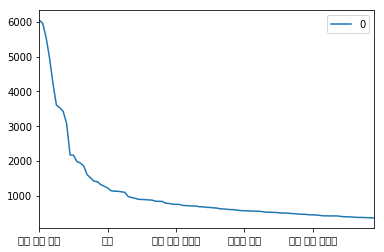

In [141]:
dist_pd_t = dist_pd.T
dist_sort = dist_pd_t.sort_values(by=0, ascending = False)
dist_sort.iloc[1:100, :].plot()

# tf-idf 가중치 적용

In [142]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True)

In [143]:
# %%time 
train_feature_tfidf = transformer.fit_transform(train_feature_vector)
train_feature_tfidf.shape

(7676, 20000)

In [144]:
# # %%time 
test_feature_tfidf = transformer.fit_transform(test_feature_vector)
test_feature_tfidf.shape

(853, 20000)

# 머신러닝 : 학습 및 평가

In [145]:
from sklearn.ensemble import RandomForestClassifier #랜덤포레스트 분류기 사용
from sklearn.model_selection import GridSearchCV  # Grid Search로 하이퍼파라미터 서치 및 모델평가.

# 랜덤포레스트 분류기를 사용
rfc = RandomForestClassifier(random_state=42)

In [146]:
# Grid Search로 초모수 찾기.
param_range = [100, 200, 300, 400, 500]
param_grid = {
    'bootstrap': [False, True],
    'n_estimators': param_range,
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [147]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring='accuracy', cv=5)

In [148]:
# y_label = df_train['result_pred']

In [149]:
CV_rfc.fit(train_feature_tfidf, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'bootstrap': [False, True], 'n_estimators': [100, 200, 300, 400, 500], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [150]:
CV_rfc.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 100}

In [151]:
CV_rfc.best_score_

0.6692287649817613

In [152]:
forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=2018, bootstrap=False, criterion='gini',
    max_depth=8, max_features='auto'
)

In [153]:
forest = forest.fit(train_feature_tfidf, y_train)

In [154]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

scoring = 'accuracy'
%time score = cross_val_score(forest, train_feature_vector, y_train, cv=k_fold, n_jobs=-1, scoring=scoring)
score

Wall time: 18.9 s


array([0.67838542, 0.67035831, 0.66644951, 0.66254072, 0.65993485])

In [155]:
round(np.mean(score)*100,2)

66.75

# 예측

In [156]:
y_train_pred = forest.predict(train_feature_vector)
y_test_pred = forest.predict(test_feature_vector)

In [157]:
# Accuracy score
from sklearn.metrics import accuracy_score
print(accuracy_score(y_train,y_train_pred))
print(accuracy_score(y_test,y_test_pred))  

0.6710526315789473
0.6471277842907386
